In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (20,3)

/tmp/ipykernel_200628/3738724887.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv("./datasetku/data-inflasi-lengkap.csv")
df = df.iloc[:,:-1]
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1969,35.56,25.25,24.51,26.04,19.80,14.42,11.01,11.61,11.61,14.41,-5.15,9.17
1,1970,15.57,13.71,10.24,14.05,14.05,17.65,15.70,12.00,9.60,7.87,10.08,9.16
2,1971,4.26,7.09,7.86,7.97,5.07,2.14,2.14,1.43,2.92,4.38,3.52,2.10
3,1972,1.36,0.66,0.66,2.01,4.14,3.50,2.80,4.23,6.38,9.09,17.69,26.03
4,1973,21.48,19.74,21.05,24.34,25.17,34.46,42.18,41.22,44.00,42.31,30.64,27.17


In [ ]:
df_melted = df.melt(id_vars=["Year"], var_name="Month", value_name="Inflasi")
months = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 
          'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

df_melted['Month'] = df_melted['Month'].map(months)
df_melted['Periode'] = pd.to_datetime(df_melted['Year'].astype(str) + '-' + df_melted['Month'].astype(str) + '-01')

df_melted

,Year,Month,Inflasi,Periode
0,1969,01,35.56,1969-01-01
1,1970,01,15.57,1970-01-01
2,1971,01,4.26,1971-01-01
3,1972,01,1.36,1972-01-01
4,1973,01,21.48,1973-01-01
...,...,...,...,...
667,2020,12,1.59,2020-12-01
668,2021,12,1.87,2021-12-01
669,2022,12,5.51,2022-12-01
670,2023,12,2.61,2023-12-01


In [4]:
df_melted = df_melted[['Periode', 'Inflasi']].sort_values(by='Periode', ascending=False)
df_cleaned = df_melted.dropna(subset=['Inflasi'])
df_cleaned

,Periode,Inflasi
447,2024-08-01,2.12
391,2024-07-01,2.13
335,2024-06-01,2.51
279,2024-05-01,2.84
223,2024-04-01,3.00
...,...,...
224,1969-05-01,19.80
168,1969-04-01,26.04
112,1969-03-01,24.51
56,1969-02-01,25.25


In [5]:
df_new = df_cleaned.reset_index(drop=True)
df_new = df_new.sort_values(by='Periode').set_index('Periode')
df_new = df_new.astype('float32')
pd.set_option('display.precision', 2)

df_new

,Inflasi
Periode,
1969-01-01,35.56
1969-02-01,25.25
1969-03-01,24.51
1969-04-01,26.04
1969-05-01,19.80
...,...
2024-04-01,3.00
2024-05-01,2.84
2024-06-01,2.51


In [6]:
print(df_new.info())
print(df_new.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 668 entries, 1969-01-01 to 2024-08-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Inflasi  668 non-null    float32
dtypes: float32(1)
memory usage: 7.8 KB
None
       Inflasi
count   668.00
mean     10.37
std      10.81
min      -5.15
25%       4.61
50%       7.72
75%      10.93
max      82.42


In [7]:
from itertools import islice

import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.dataset.split import split

from lag_llama.gluon.estimator import LagLlamaEstimator

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [8]:
dataset = PandasDataset(df_new, target='Inflasi')
print(dataset)

PandasDataset<size=1, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>


In [9]:
#Checking dataset
entry = next(iter(dataset))
print(entry)

{'start': Period('1969-01', 'M'), 'target': array([ 3.556e+01,  2.525e+01,  2.451e+01,  2.604e+01,  1.980e+01,
        1.442e+01,  1.101e+01,  1.161e+01,  1.161e+01,  1.441e+01,
       -5.150e+00,  9.170e+00,  1.557e+01,  1.371e+01,  1.024e+01,
        1.405e+01,  1.405e+01,  1.765e+01,  1.570e+01,  1.200e+01,
        9.600e+00,  7.870e+00,  1.008e+01,  9.160e+00,  4.260e+00,
        7.090e+00,  7.860e+00,  7.970e+00,  5.070e+00,  2.140e+00,
        2.140e+00,  1.430e+00,  2.920e+00,  4.380e+00,  3.520e+00,
        2.100e+00,  1.360e+00,  6.600e-01,  6.600e-01,  2.010e+00,
        4.140e+00,  3.500e+00,  2.800e+00,  4.230e+00,  6.380e+00,
        9.090e+00,  1.769e+01,  2.603e+01,  2.148e+01,  1.974e+01,
        2.105e+01,  2.434e+01,  2.517e+01,  3.446e+01,  4.218e+01,
        4.122e+01,  4.400e+01,  4.231e+01,  3.064e+01,  2.717e+01,
        4.254e+01,  4.670e+01,  4.728e+01,  4.921e+01,  4.921e+01,
        4.322e+01,  3.684e+01,  3.684e+01,  3.519e+01,  3.514e+01,
        3.540e+01,

In [10]:
print(len(entry["target"]))
print(entry["start"])

668
1969-01


In [11]:
print(df_new.iloc[:534])
print(len(df_new.iloc[:534]))
print(df_new.iloc[534:])
print(len(df_new.iloc[534:]))

            Inflasi
Periode            
1969-01-01    35.56
1969-02-01    25.25
1969-03-01    24.51
1969-04-01    26.04
1969-05-01    19.80
...             ...
2013-02-01     4.81
2013-03-01     5.24
2013-04-01     5.07
2013-05-01     5.10
2013-06-01     5.51

[534 rows x 1 columns]
534
            Inflasi
Periode            
2013-07-01     7.94
2013-08-01     7.98
2013-09-01     7.70
2013-10-01     7.72
2013-11-01     7.82
...             ...
2024-04-01     3.00
2024-05-01     2.84
2024-06-01     2.51
2024-07-01     2.13
2024-08-01     2.12

[134 rows x 1 columns]
134


In [12]:
def highlight_entry(entry, color):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    plt.axvspan(start, end, facecolor=color, alpha=0.2)

def plot_dataset_splitting(ori_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(ori_dataset, training_dataset):
        to_pandas(original_entry).plot()
        highlight_entry(train_entry, "red")
        plt.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in ori_dataset:
        for test_input, test_label in test_pairs:
            to_pandas(original_entry).plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()

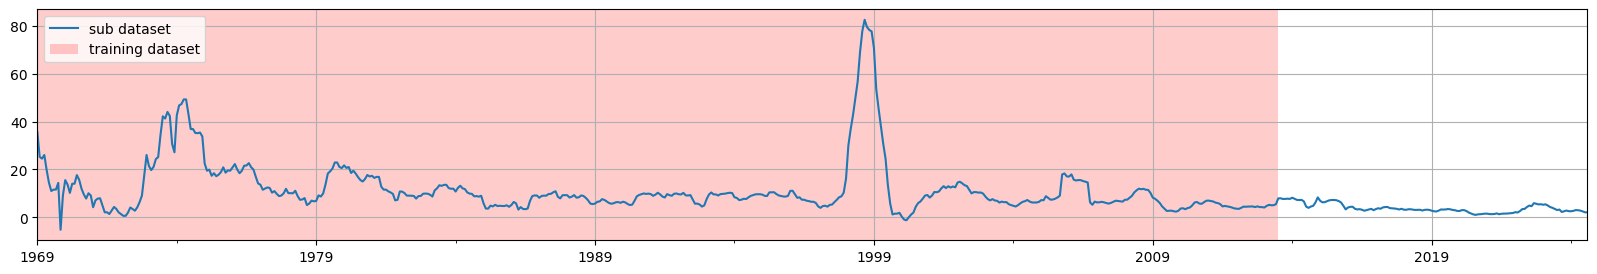

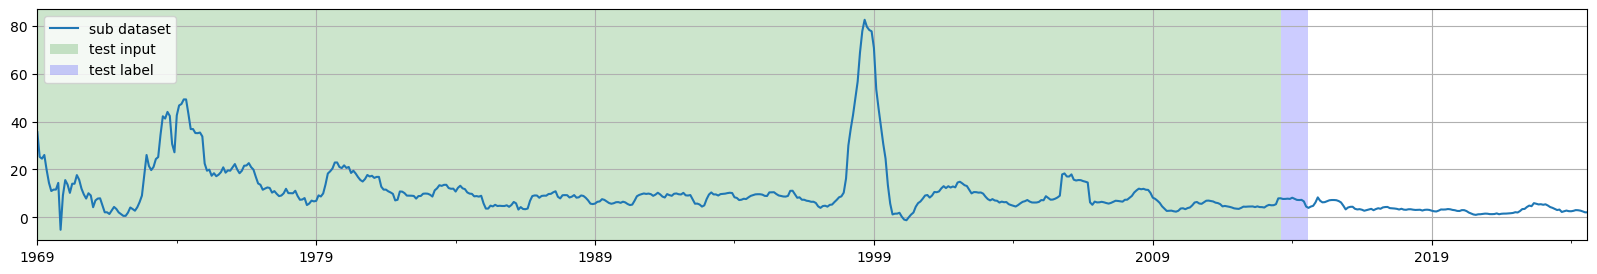

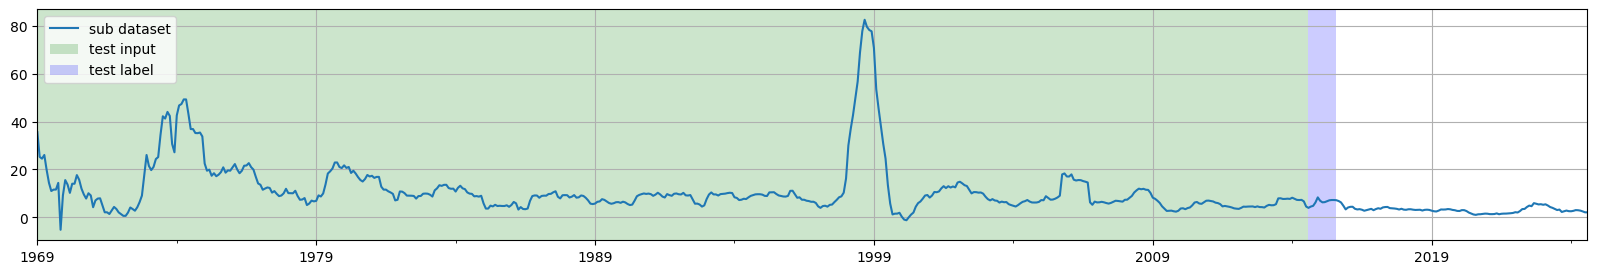

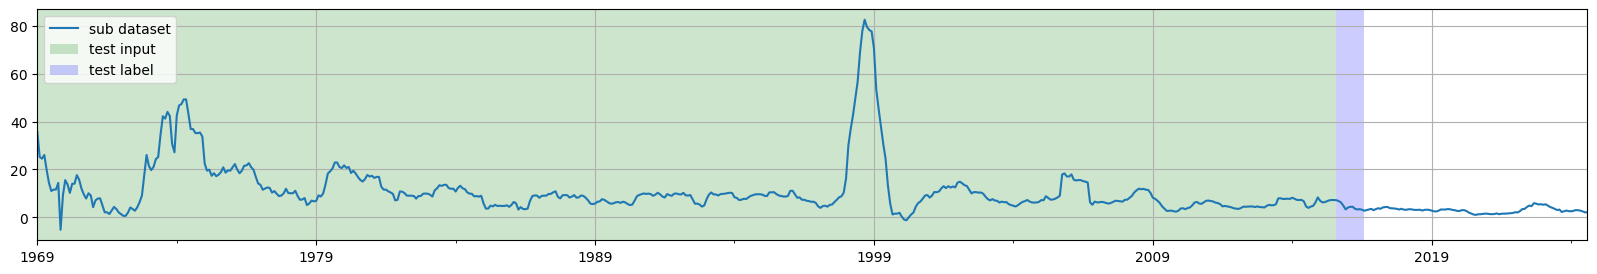

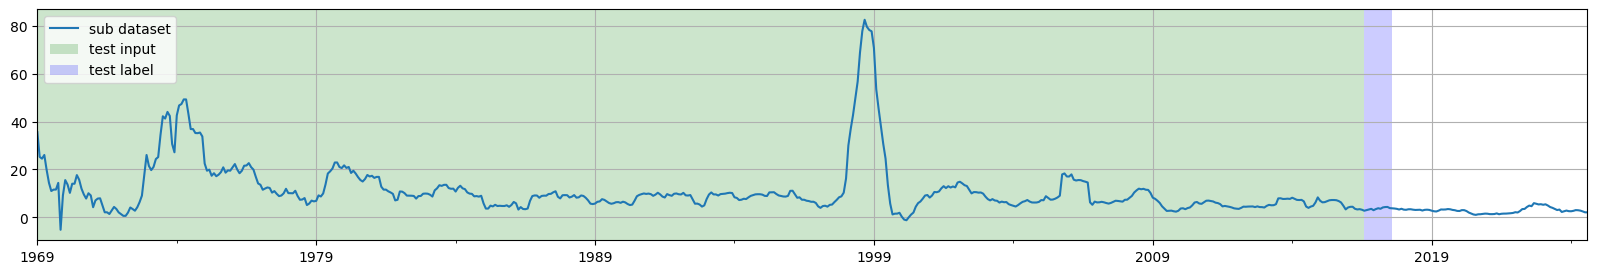

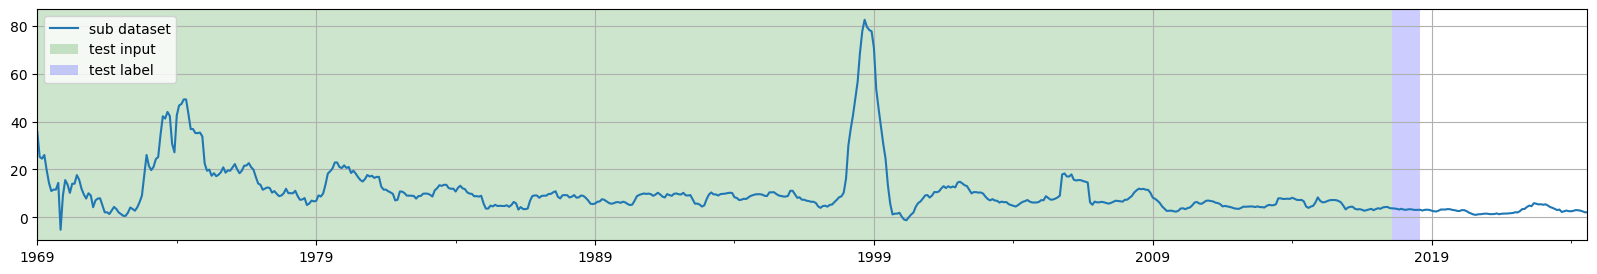

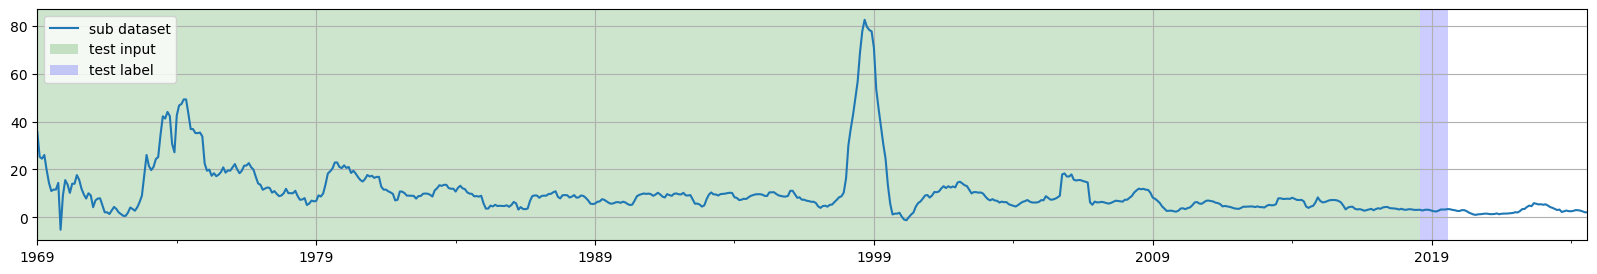

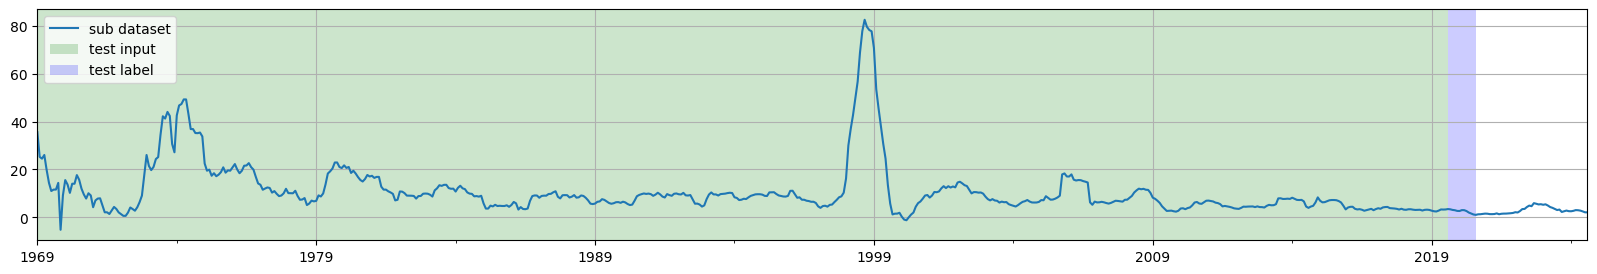

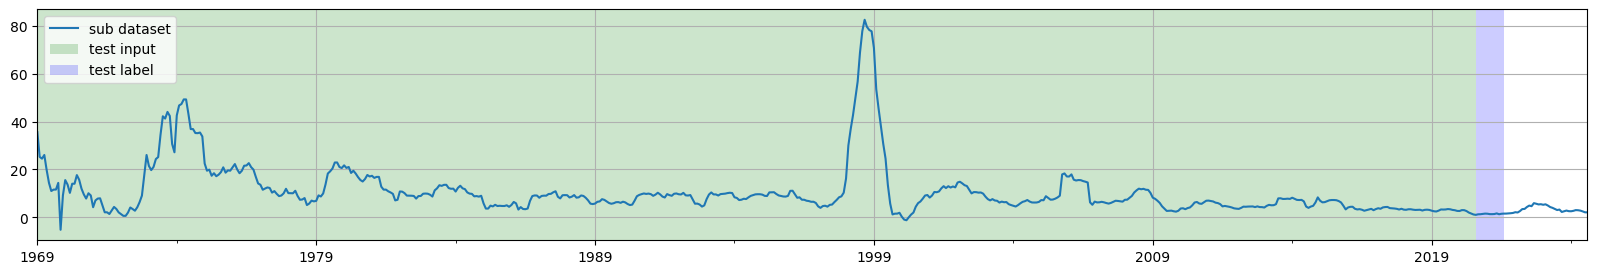

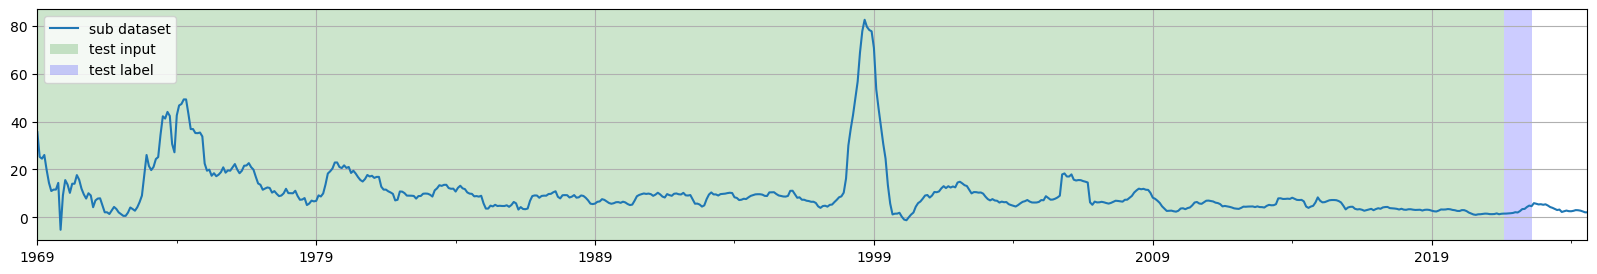

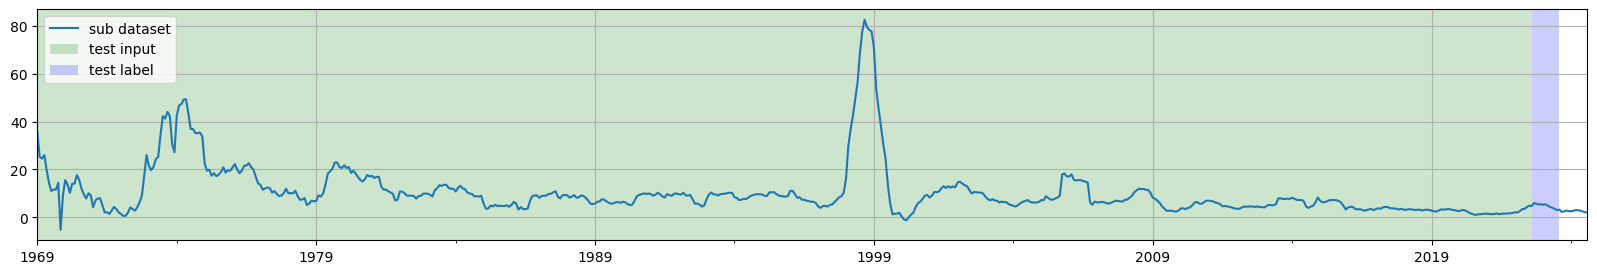

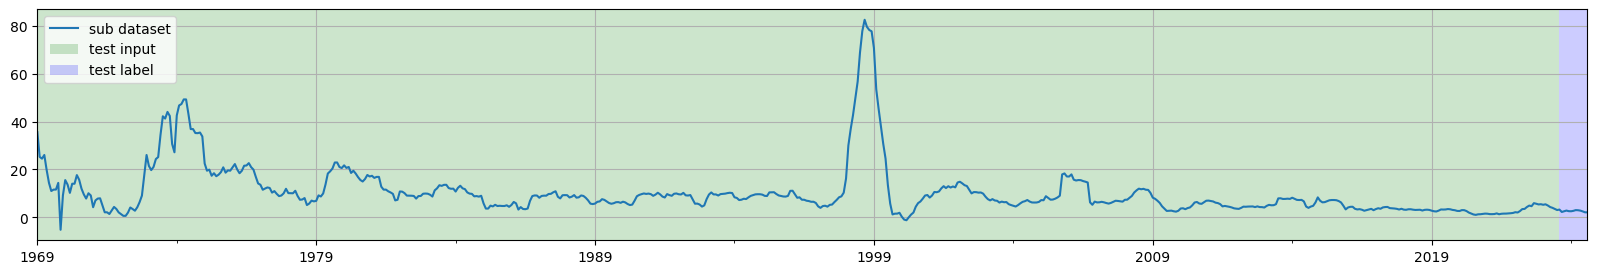

In [13]:
prediction_length = 12
training_dataset, _ = split(dataset, date=pd.Period("2013-06-01", freq="M"))
_, test_template = split(dataset, date=pd.Period("2013-07-01", freq="M"))
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=11,
)

plot_dataset_splitting(dataset, training_dataset, test_pairs)

In [14]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=4,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [15]:
print("TEST INPUT:\n",next(iter(test_pairs.input)))
print("LABEL INPUT:\n",next(iter(test_pairs.label)))

TEST INPUT:
 {'start': Period('1969-01', 'M'), 'target': array([ 3.556e+01,  2.525e+01,  2.451e+01,  2.604e+01,  1.980e+01,
        1.442e+01,  1.101e+01,  1.161e+01,  1.161e+01,  1.441e+01,
       -5.150e+00,  9.170e+00,  1.557e+01,  1.371e+01,  1.024e+01,
        1.405e+01,  1.405e+01,  1.765e+01,  1.570e+01,  1.200e+01,
        9.600e+00,  7.870e+00,  1.008e+01,  9.160e+00,  4.260e+00,
        7.090e+00,  7.860e+00,  7.970e+00,  5.070e+00,  2.140e+00,
        2.140e+00,  1.430e+00,  2.920e+00,  4.380e+00,  3.520e+00,
        2.100e+00,  1.360e+00,  6.600e-01,  6.600e-01,  2.010e+00,
        4.140e+00,  3.500e+00,  2.800e+00,  4.230e+00,  6.380e+00,
        9.090e+00,  1.769e+01,  2.603e+01,  2.148e+01,  1.974e+01,
        2.105e+01,  2.434e+01,  2.517e+01,  3.446e+01,  4.218e+01,
        4.122e+01,  4.400e+01,  4.231e+01,  3.064e+01,  2.717e+01,
        4.254e+01,  4.670e+01,  4.728e+01,  4.921e+01,  4.921e+01,
        4.322e+01,  3.684e+01,  3.684e+01,  3.519e+01,  3.514e+01,
     

In [16]:
backtest_dataset = test_pairs.input
prediction_length = 12
num_samples = 4
device = torch.device("cuda:0")

In [17]:
#Get predictions
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

/tmp/ipykernel_200628/3645707569.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU si

In [24]:
print(len(forecasts))
print(forecasts)
# print(forecasts.samples.shape)
# print(next(iter(forecasts)))
print(forecasts[1].samples.shape)
print(tss)

11
[gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[ 5.1118007 ,  3.6600347 ,  3.0510855 , ...,  5.867018  ,
         5.998165  ,  2.2471738 ],
       [ 3.3395486 ,  2.3214927 ,  2.4846392 , ...,  2.3856406 ,
         2.2584224 ,  3.1938539 ],
       [ 4.7293653 ,  4.297555  ,  3.8732395 , ...,  2.1960688 ,
         1.0353632 ,  0.62707806],
       ...,
       [ 4.4202733 ,  4.851623  ,  2.2501006 , ..., -7.6125736 ,
        -2.9075184 , -3.3479958 ],
       [ 4.8153796 ,  4.7029443 ,  4.61977   , ...,  3.368688  ,
         3.0204706 ,  2.9617157 ],
       [ 4.5266824 ,  3.3088808 ,  3.7764363 , ..., -0.760334  ,
         0.31661034,  0.2519331 ]], dtype=float32), start_date=Period('2012-08', 'M')), gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[  6.6520834 ,   5.959445  ,   5.608443  , ...,   3.9470935 ,
          2.3637629 ,   1.7148466 ],
       [  7.395578  ,   6.889038  ,   5.3927355 , ...,   0.23922253,
         -0.86

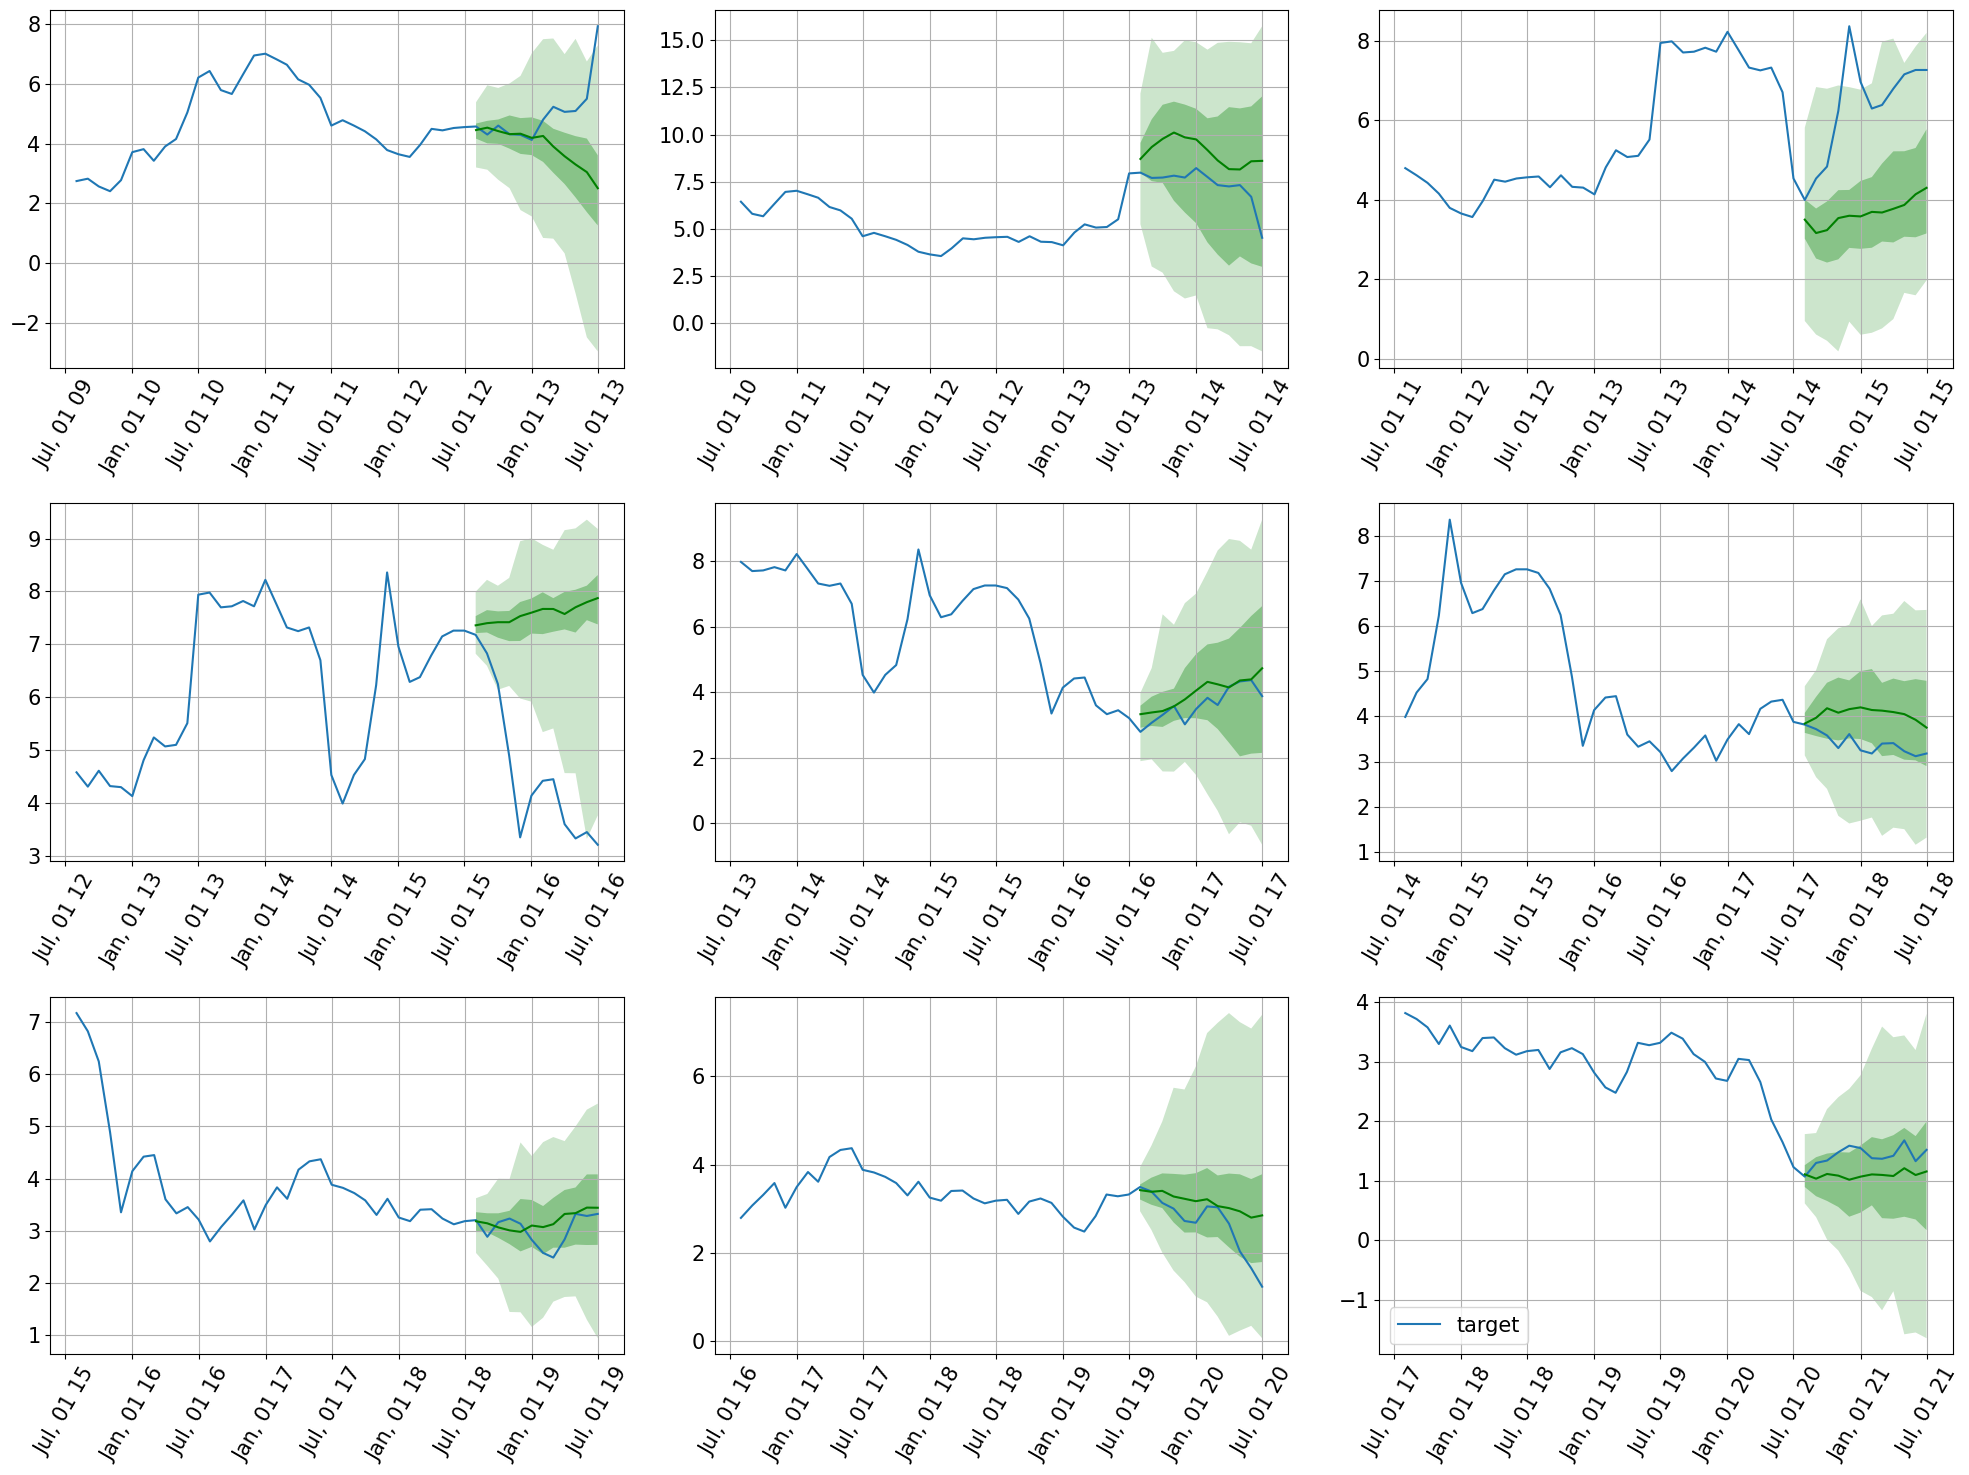

In [19]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d %y')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [20]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 11it [00:00, 311.98it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [21]:
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])

CRPS: 0.24119393817266901
MSE: 2.7497198708129655
MAPE: 0.2957615518208706


In [22]:
#Context Length: 64
forecasts_ctx_len_64, tss_ctx_len_64 = get_lag_llama_predictions(backtest_dataset, prediction_length=12, device=device, \
                                           context_length=64, use_rope_scaling=True, num_samples=30)
forecasts_ctx_len_64 = list(forecasts_ctx_len_64)
tss_ctx_len_64 = list(tss_ctx_len_64)

agg_metrics_ctx_len_64, ts_metrics_ctx_len_64 = evaluator(iter(tss_ctx_len_64), iter(forecasts_ctx_len_64))
print("CRPS:", agg_metrics_ctx_len_64['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_64['MSE'])
print('MAPE:', agg_metrics_ctx_len_64['MAPE'])

/tmp/ipykernel_938915/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

CRPS: 0.23812083438537698
MSE: 2.034276153553616
MAPE: 0.29065495187586005


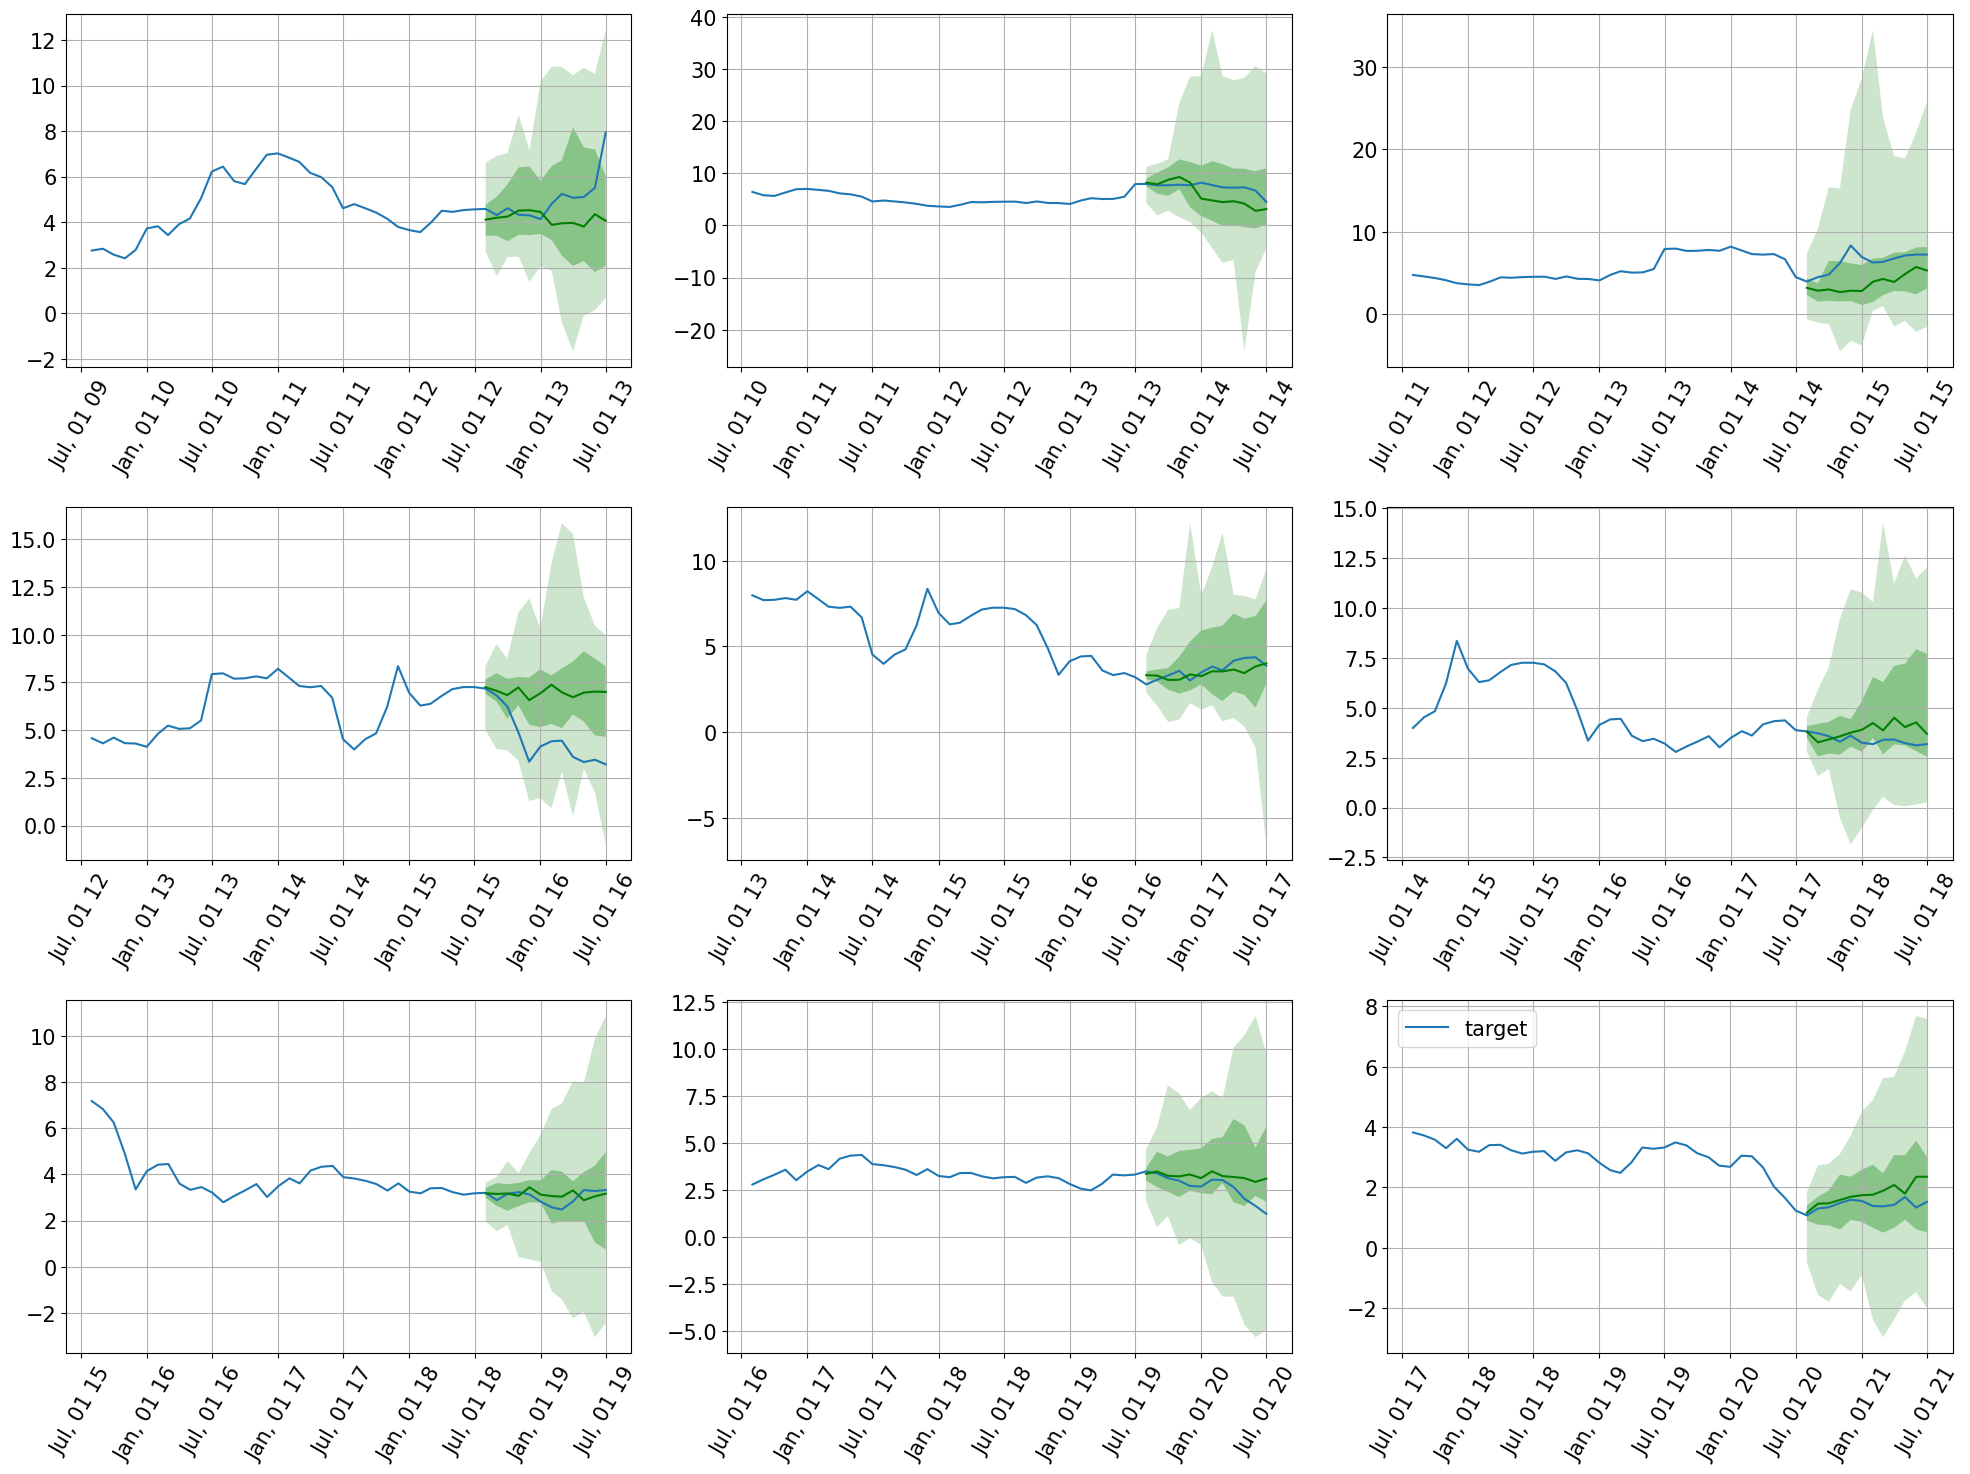

In [23]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d %y')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_64, tss_ctx_len_64)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [24]:
#Context Length: 128
forecasts_ctx_len_128, tss_ctx_len_128 = get_lag_llama_predictions(backtest_dataset, prediction_length=12, device=device, \
                                           context_length=128, use_rope_scaling=True, num_samples=30)
forecasts_ctx_len_128 = list(forecasts_ctx_len_128)
tss_ctx_len_128 = list(tss_ctx_len_128)

agg_metrics_ctx_len_128, ts_metrics_ctx_len_128 = evaluator(iter(tss_ctx_len_128), iter(forecasts_ctx_len_128))
print("CRPS:", agg_metrics_ctx_len_128['mean_wQuantileLoss'])
print('MSE:', agg_metrics_ctx_len_128['MSE'])
print('MAPE:', agg_metrics_ctx_len_128['MAPE'])

/tmp/ipykernel_938915/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

CRPS: 0.2717913703715371
MSE: 3.412677974411935
MAPE: 0.3514439788731662


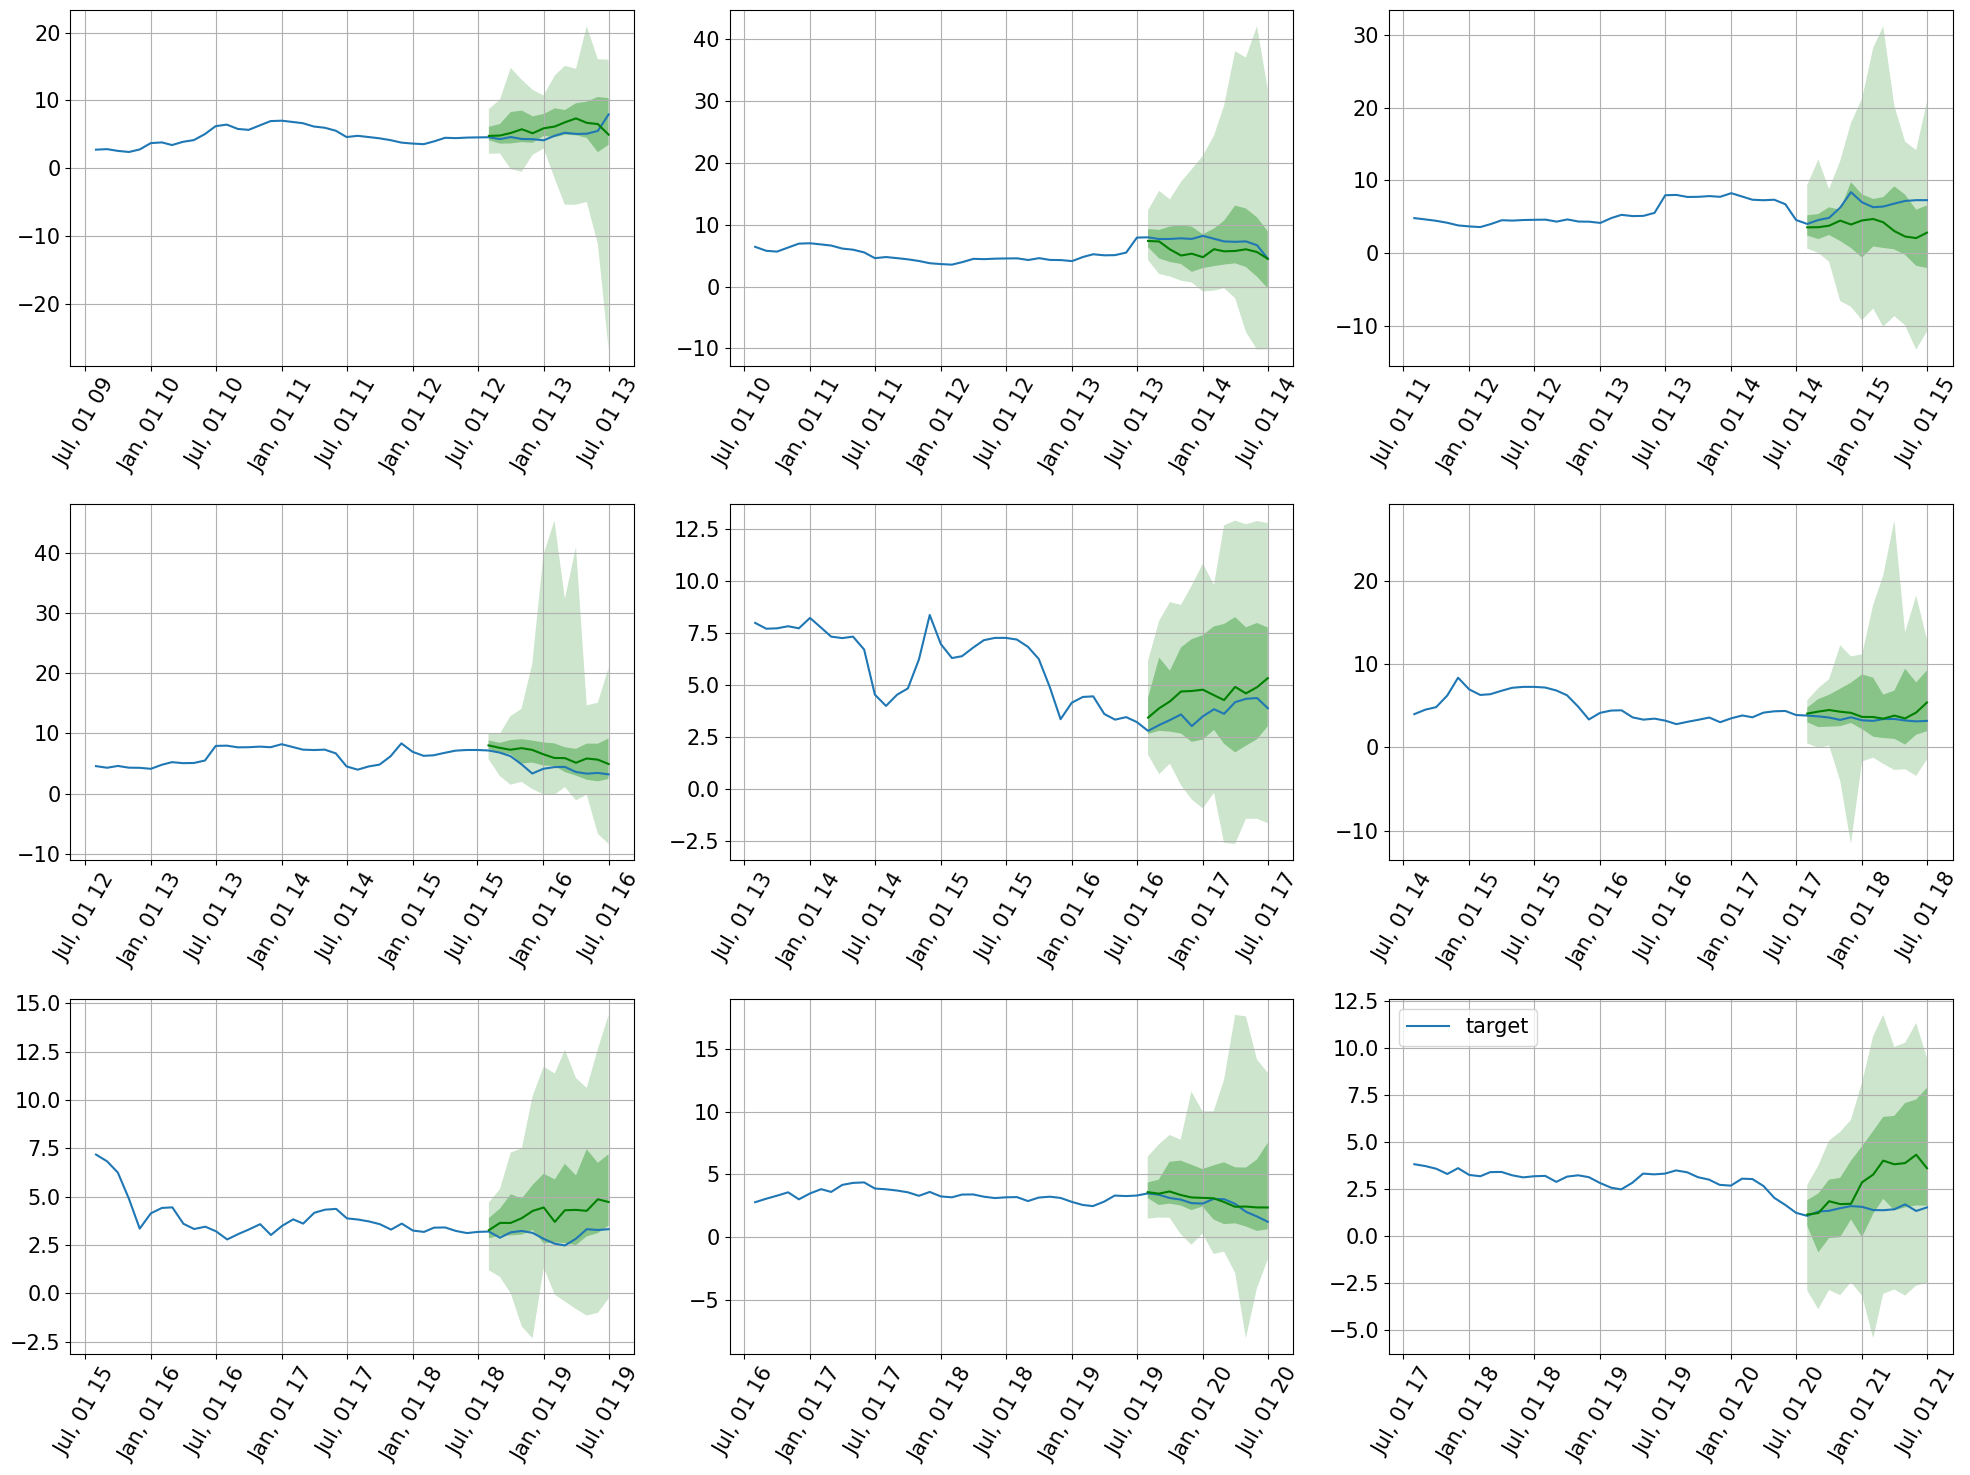

In [26]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d %y')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_ctx_len_128, tss_ctx_len_128)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [45]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=128,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

/tmp/ipykernel_938915/1448420959.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)


In [46]:
predictor = estimator.train(
    training_dataset,
    cache_data=True,
    shuffle_buffer_length=1000,
)

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Trainer will use only 1 of 2 GP

Epoch 0: |          | 50/? [00:03<00:00, 12.72it/s, v_num=6]

Epoch 0, global step 50: 'train_loss' reached 2.06367 (best 2.06367), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:04<00:00, 12.47it/s, v_num=6]

Epoch 1, global step 100: 'train_loss' reached 1.44102 (best 1.44102), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:04<00:00, 12.49it/s, v_num=6]

Epoch 2, global step 150: 'train_loss' reached 1.03801 (best 1.03801), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:04<00:00, 12.48it/s, v_num=6]

Epoch 3, global step 200: 'train_loss' reached 0.80258 (best 0.80258), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:04<00:00, 12.49it/s, v_num=6]

Epoch 4, global step 250: 'train_loss' reached 0.70373 (best 0.70373), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:04<00:00, 12.48it/s, v_num=6]

Epoch 5, global step 300: 'train_loss' reached 0.45240 (best 0.45240), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:04<00:00, 12.47it/s, v_num=6]

Epoch 6, global step 350: 'train_loss' reached 0.31065 (best 0.31065), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:04<00:00, 12.48it/s, v_num=6]

Epoch 7, global step 400: 'train_loss' reached 0.09136 (best 0.09136), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:04<00:00, 12.48it/s, v_num=6]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:04<00:00, 12.45it/s, v_num=6]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 10, global step 550: 'train_loss' reached -0.02046 (best -0.02046), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 11, global step 600: 'train_loss' reached -0.17070 (best -0.17070), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:04<00:00, 12.45it/s, v_num=6]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [00:04<00:00, 12.45it/s, v_num=6]

Epoch 16, global step 850: 'train_loss' reached -0.18406 (best -0.18406), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 19, global step 1000: 'train_loss' reached -0.27994 (best -0.27994), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=19-step=1000.ckpt' as top 1


Epoch 20: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 20, global step 1050: 'train_loss' reached -0.43146 (best -0.43146), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=20-step=1050.ckpt' as top 1


Epoch 21: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 21, global step 1100: 'train_loss' reached -0.43191 (best -0.43191), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=21-step=1100.ckpt' as top 1


Epoch 22: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 23, global step 1200: 'train_loss' reached -0.43413 (best -0.43413), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 24, global step 1250: 'train_loss' reached -0.55808 (best -0.55808), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=24-step=1250.ckpt' as top 1


Epoch 25: |          | 50/? [00:04<00:00, 12.42it/s, v_num=6]

Epoch 25, global step 1300: 'train_loss' was not in top 1


Epoch 26: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 29, global step 1500: 'train_loss' reached -0.63939 (best -0.63939), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=29-step=1500.ckpt' as top 1


Epoch 30: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 31, global step 1600: 'train_loss' reached -0.68959 (best -0.68959), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=31-step=1600.ckpt' as top 1


Epoch 32: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 33, global step 1700: 'train_loss' was not in top 1


Epoch 34: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:04<00:00, 12.41it/s, v_num=6]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 38, global step 1950: 'train_loss' reached -0.76778 (best -0.76778), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:04<00:00, 12.42it/s, v_num=6]

Epoch 39, global step 2000: 'train_loss' was not in top 1


Epoch 40: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 40, global step 2050: 'train_loss' reached -0.79750 (best -0.79750), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=40-step=2050.ckpt' as top 1


Epoch 41: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:04<00:00, 12.42it/s, v_num=6]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 43, global step 2200: 'train_loss' reached -0.84105 (best -0.84105), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=43-step=2200.ckpt' as top 1


Epoch 44: |          | 50/? [00:04<00:00, 12.42it/s, v_num=6]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:04<00:00, 12.41it/s, v_num=6]

Epoch 46, global step 2350: 'train_loss' reached -0.90583 (best -0.90583), saving model to '/home/abizard/lag-llama-code/lag-llama/lightning_logs/version_6/checkpoints/epoch=46-step=2350.ckpt' as top 1


Epoch 47: |          | 50/? [00:04<00:00, 12.42it/s, v_num=6]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:04<00:00, 12.44it/s, v_num=6]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [00:04<00:00, 12.43it/s, v_num=6]

Epoch 49, global step 2500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: |          | 50/? [00:04<00:00, 12.24it/s, v_num=6]


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [47]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )

In [48]:
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))

Forecasting batches: 11it [00:01,  8.41it/s]                      


In [49]:
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

Ground truth: 11it [00:00, 9347.11it/s]            


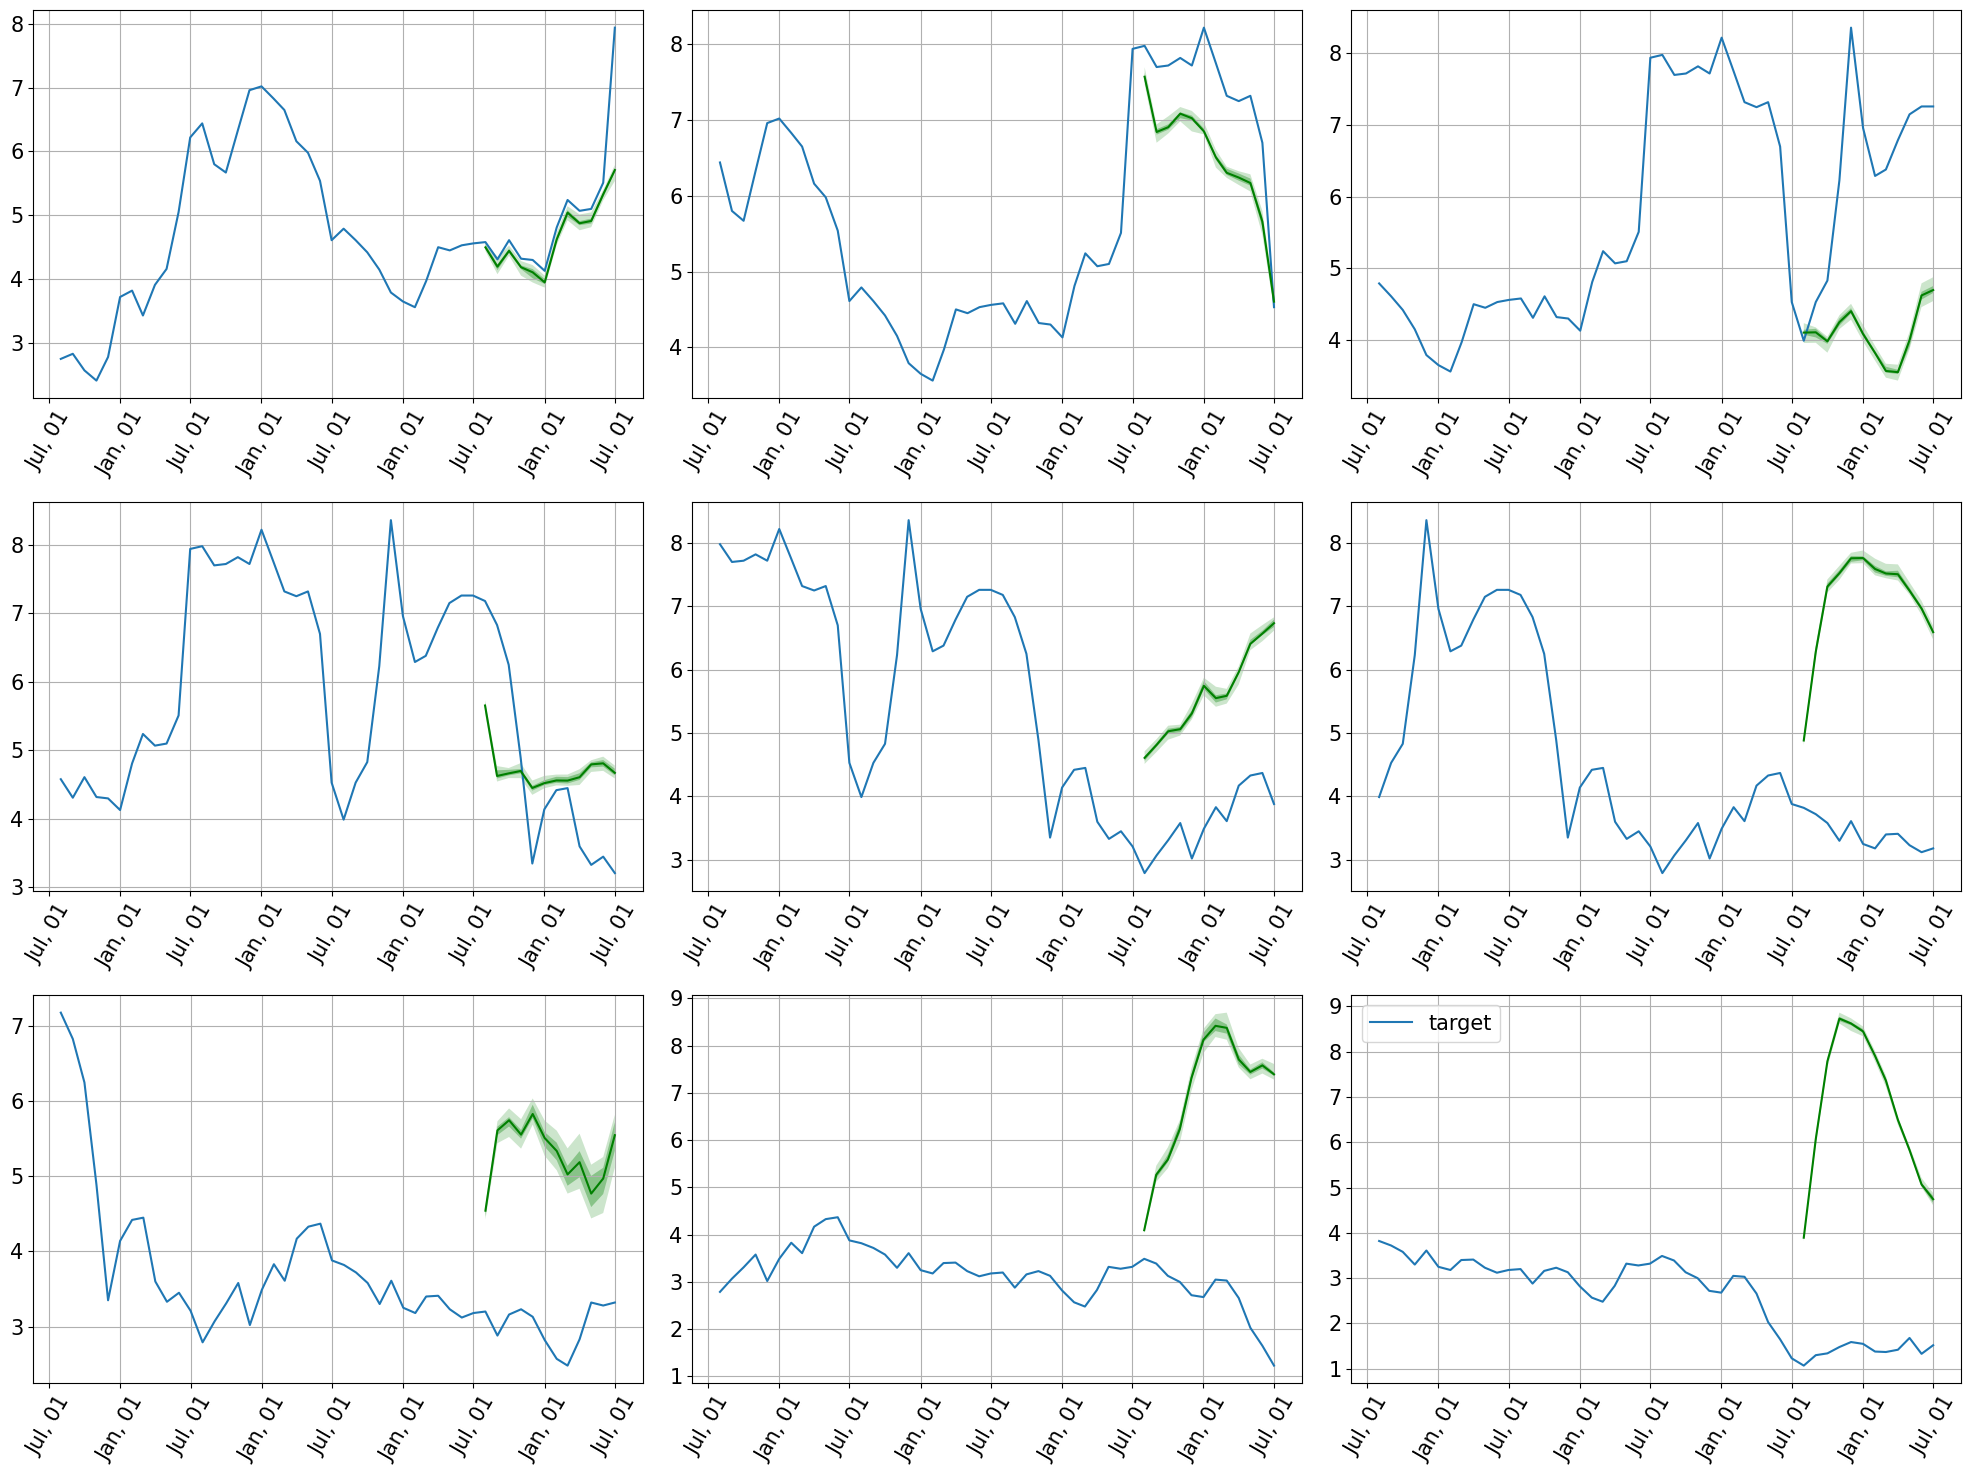

In [50]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [51]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

print("CRPS:", agg_metrics['mean_wQuantileLoss'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])

Running evaluation: 11it [00:00, 394.35it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


CRPS: 0.6313035654397798
MSE: 9.982568516875759
MAPE: 1.0249271550864885
